## Notebook 1: Regression of energy consumption

**1. Prepare Problem**

In [1]:
# a) Load libraries
import pandas as pd
from pandas import set_option
from pandas import DataFrame

import numpy as np

import matplotlib.pyplot as plt

import xgboost as xgb
from tensorflow import keras
from keras.callbacks import EarlyStopping
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from keras.layers import BatchNormalization, Dropout, Dense 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score

from pickle import dump

import warnings
warnings.filterwarnings("ignore", message="pandas.Int64Index is deprecated")

D:\Software\Anaconda\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
# b) Load dataset
# Load and view each file in the dataset
data = pd.read_csv('EPB_data.csv', header=0)
print(data.shape)
print(data.head(10))
print(data.dtypes)

(768, 10)
   Relative Compactness  Surface Area  Wall Area  Roof Area  Overall Height  \
0                  0.98         514.5      294.0     110.25             7.0   
1                  0.98         514.5      294.0     110.25             7.0   
2                  0.98         514.5      294.0     110.25             7.0   
3                  0.98         514.5      294.0     110.25             7.0   
4                  0.90         563.5      318.5     122.50             7.0   
5                  0.90         563.5      318.5     122.50             7.0   
6                  0.90         563.5      318.5     122.50             7.0   
7                  0.90         563.5      318.5     122.50             7.0   
8                  0.86         588.0      294.0     147.00             7.0   
9                  0.86         588.0      294.0     147.00             7.0   

   Orientation  Glazing Area  Glazing Area Distribution  Heating Load  \
0            2           0.0                   

One of the approach in optimizing building energy efficiency is to minimize total energy consumption, which is the sum of heating and cooling.

In [3]:
# Calculate total energy consumption by summing up heating and cooling loads
data['Energy Consumption'] = data[['Heating Load', 'Cooling Load']].sum(axis=1)
print(data.shape)

# Define features and label
X = data.drop(columns=['Heating Load', 'Cooling Load', 'Energy Consumption'], axis = 1)
y = data['Energy Consumption']

(768, 11)


**2. Dataset summary**

In [4]:
# a) Descriptive statistics
set_option("display.precision", 3)
print(data.describe())

       Relative Compactness  Surface Area  Wall Area  Roof Area  \
count               768.000       768.000    768.000    768.000   
mean                  0.764       671.708    318.500    176.604   
std                   0.106        88.086     43.626     45.166   
min                   0.620       514.500    245.000    110.250   
25%                   0.682       606.375    294.000    140.875   
50%                   0.750       673.750    318.500    183.750   
75%                   0.830       741.125    343.000    220.500   
max                   0.980       808.500    416.500    220.500   

       Overall Height  Orientation  Glazing Area  Glazing Area Distribution  \
count         768.000      768.000       768.000                    768.000   
mean            5.250        3.500         0.234                      2.812   
std             1.751        1.119         0.133                      1.551   
min             3.500        2.000         0.000                      0.000   
2

In [5]:
# checking categorical features
cat_features = data.select_dtypes(include='O').keys()
# display variabels
cat_features

Index([], dtype='object')

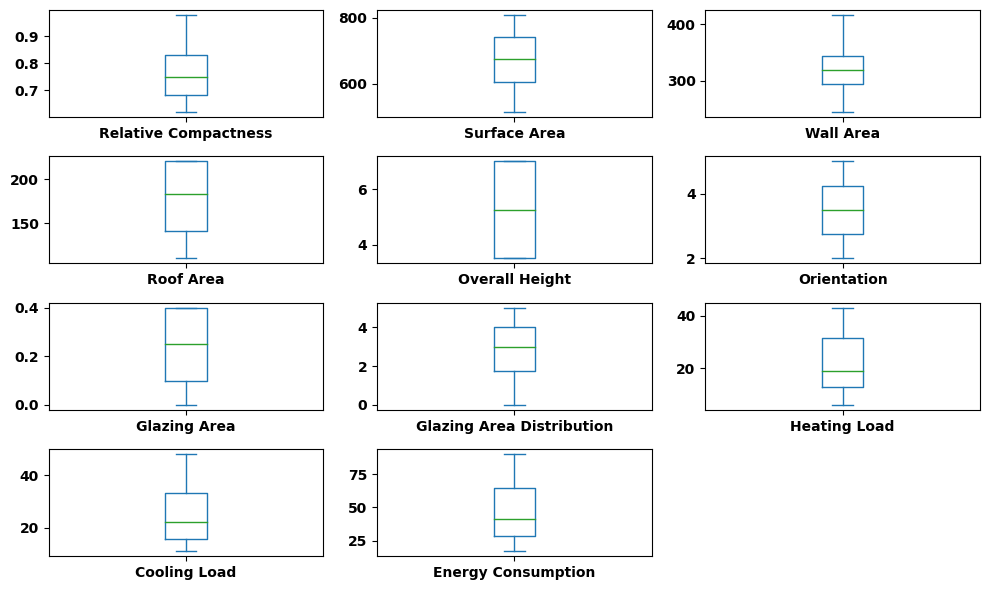

In [6]:
# b) Data visualizations
# Box and Whisker Plots of a few features

plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.autolayout"] = True

raw_plot = pd.DataFrame(data)
raw_plot.plot(kind='box', subplots=True, layout=(4,3), sharex=False, sharey=False)
plt.show()

We can see the data skewed to high values in relative compactness, roof area, glazing area, and cooling load.

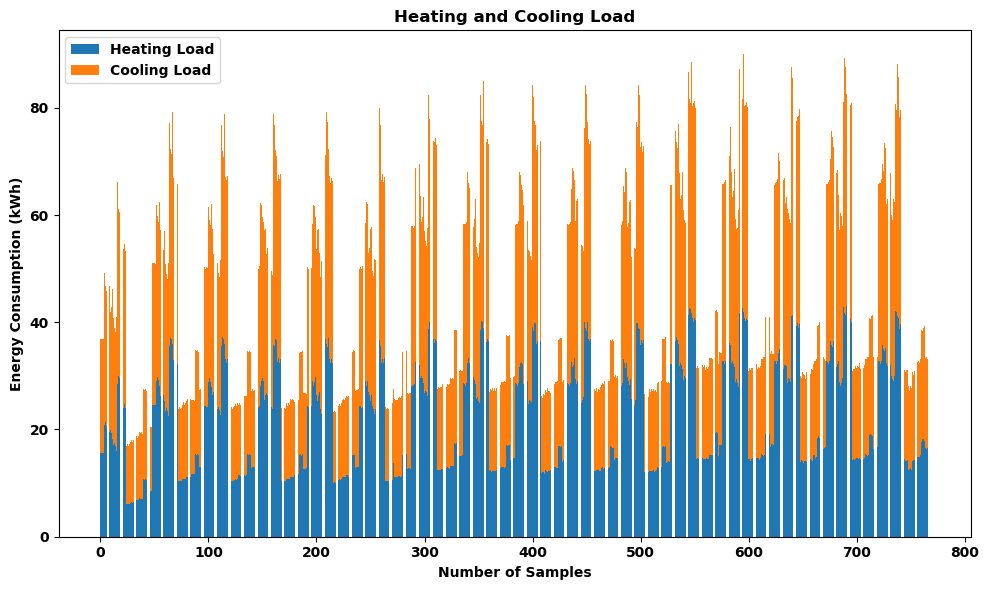

In [7]:
# create the stack bar chart of Heating and Cooling Load
fig, ax = plt.subplots()
ax.bar(np.arange(len(data['Heating Load'])), data['Heating Load'], label='Heating Load')
ax.bar(np.arange(len(data['Cooling Load'])), data['Cooling Load'], bottom=data['Heating Load'], label='Cooling Load')

# add labels, title and legend
ax.set_xlabel('Number of Samples')
ax.set_ylabel('Energy Consumption (kWh)')
ax.set_title('Heating and Cooling Load')
ax.legend()

# show the plot
plt.show()

The data displays a cyclical pattern that may have resulted from the measurements taken on weekdays (with longer hours) and weekends.

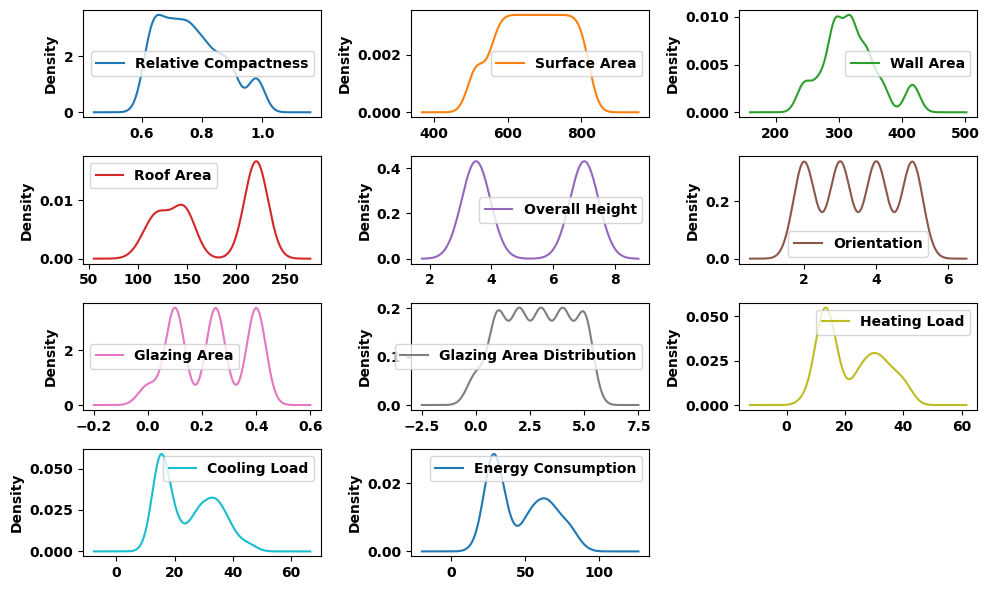

In [8]:
# Create density plots to check the Gaussian distribution of features
raw_plot.plot(kind='density', subplots=True, layout=(4,3), sharex=False)
plt.show()

The dataset seems to be complex as most of features exhibit non-Gaussian distributions, except for the Surface Area. There are several factors that could cause non-Gaussian distributions, including outliers, measurement errors, or the inherent characteristics of the building designs.

                           Relative Compactness  Surface Area  Wall Area  \
Relative Compactness                  1.000e+00    -9.919e-01 -2.038e-01   
Surface Area                         -9.919e-01     1.000e+00  1.955e-01   
Wall Area                            -2.038e-01     1.955e-01  1.000e+00   
Roof Area                            -8.688e-01     8.807e-01 -2.923e-01   
Overall Height                        8.277e-01    -8.581e-01  2.810e-01   
Orientation                           4.679e-17    -3.459e-17 -2.429e-17   
Glazing Area                         -2.961e-15     3.637e-15 -8.567e-17   
Glazing Area Distribution            -7.107e-16     2.438e-15  2.067e-16   
Heating Load                          6.223e-01    -6.581e-01  4.557e-01   
Cooling Load                          6.343e-01    -6.730e-01  4.271e-01   
Energy Consumption                    6.319e-01    -6.694e-01  4.445e-01   

                           Roof Area  Overall Height  Orientation  \
Relative Compactne

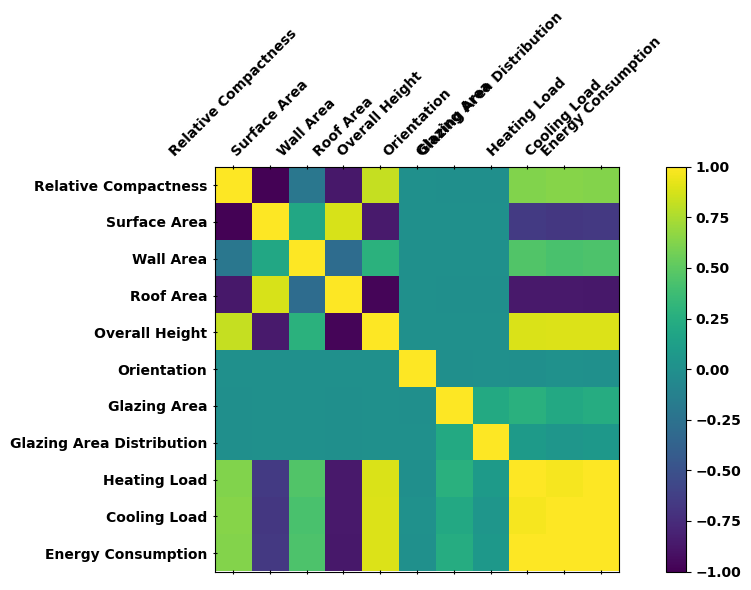

In [9]:
# correlation matrix between all pairs of attributes
print(data.corr(method='pearson'))
names = list(data)
fig = plt.figure()
sub_fig = fig.add_subplot(111)
cm = sub_fig.matshow(data.corr(), vmin=-1, vmax=1, interpolation='none')
fig.colorbar(cm)
sub_fig.tick_params(direction='inout')
sub_fig.set_xticks(np.arange(0,11))
sub_fig.set_yticks(np.arange(0,11))
sub_fig.set_xticklabels(names, rotation=45)
sub_fig.set_yticklabels(names)
plt.show()

According to the correlation matrix, the heating and cooling loads, as well as energy consumption, exhibit strong correlations with the overall height, orientation, and to some extent, the surface area. The orientation is considered to be an uncertain factor in building design due to limited choices compared to other variables and it plays a significant role in determining the energy efficiency of a building.

**3. Prepare Data**

In [10]:
# a) Data Cleaning
# summarize the number of unique values in each column
print(data.nunique())

Relative Compactness          12
Surface Area                  12
Wall Area                      7
Roof Area                      4
Overall Height                 2
Orientation                    4
Glazing Area                   4
Glazing Area Distribution      6
Heating Load                 586
Cooling Load                 636
Energy Consumption           700
dtype: int64


In [11]:
# Identify columns with missing values and count the number of missing values
data.columns[data.isnull().any()]
print(data.isnull().sum())

Relative Compactness         0
Surface Area                 0
Wall Area                    0
Roof Area                    0
Overall Height               0
Orientation                  0
Glazing Area                 0
Glazing Area Distribution    0
Heating Load                 0
Cooling Load                 0
Energy Consumption           0
dtype: int64


It is necessary to eliminate outliers in numerical data columns to improve the accuracy of training and validation processes. This can be done by determining the correlation between these columns and the target variable, identifying columns with low correlation, and then filtering out values that fall outside of the lower and upper bounds.

In [12]:
# calculate the correlation between numerical columns and target variable
corr_matrix = data.select_dtypes(include=np.number).corrwith(data['Energy Consumption']).sort_values(ascending=False)

# filter columns with low correlation 
corr_threshold = 0.05
low_corr_columns = corr_matrix[corr_matrix.abs() < corr_threshold].index

# remove outliers from numerical columns with low correlation
for column in low_corr_columns:
    lower = data[column].quantile(0.01)
    upper = data[column].quantile(0.99)
    data[column] = data[column].clip(lower, upper)

In [13]:
# b) Split-out dataset into train and validation sets

X = data.drop(columns=['Heating Load', 'Cooling Load', 'Energy Consumption'], axis = 1)
y = data['Energy Consumption']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=1)

print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

# For XGBoost model
X_train1 = X_train
y_train1 = y_train
X_val1 = X_val

(537, 8) (537,) (231, 8) (231,)


In [14]:
# c) Data Transforms
# Standardize the dataset by rescaling the distribution of values 

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)

**4. Evaluate Algorithms**

In [15]:
# a) Spot check algorithms using cross-validation technique
num_folds = 8
seed = 8

# Select 3 most popular algorithms for evaluation
models = []
models.append(('LR', LinearRegression()))
models.append(('RF', RandomForestRegressor()))

# Define the XGBoost model
model_xgb = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 1,
                max_depth = 5, alpha = 10, n_estimators = 10)
models.append(('XGB', model_xgb))

In [16]:
# Neural Network algorithms
# create keras Sequential model
def baseline_model():
    model = Sequential()
    model.add(Dense(300, input_shape = (8, ), activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(200, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(100, activation = 'relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer = 'adam',
                loss = 'mean_squared_error',
                metrics=['mse'])
    return model

# Build model
model_NN = baseline_model()
models.append(('NN', model_NN))

In [17]:
# Define a callback for early stopping if the validation loss does not improve for 10 consecutive 
# epochs (patience=10).
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

In [18]:
results = []
alg_names = []

# Initialize the KerasRegressor estimator with early stopping
estimator = KerasRegressor(model=model_NN, batch_size=128, verbose=1, callbacks=[early_stopping])

for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    
    # modify loop for xgboost and NN
    if name != ('XGB' and 'NN'):
        cvs = cross_val_score(model, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
    else:    
        if name == 'NN':
            validation_data = (X_val, y_val)
            cvs = cross_val_score(estimator, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error', fit_params={'validation_data': validation_data, 'epochs': 150})
        else:
            # create DMatrix from training data for XGBoost
            dtrain = xgb.DMatrix(X_train1, label=y_train1)
            cvs = cross_val_score(model_xgb, X_train1, y_train1, cv=kfold, scoring='neg_mean_squared_error')
    
    results.append(cvs)
    alg_names.append(name)
    output = "%s: %f (%f)" % (name, cvs.mean(), cvs.std())
    print(output)

LR: -30.969344 (9.052568)
RF: -3.013510 (0.997504)
XGB: -2.775281 (0.646914)
INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmp0wxjodbl\assets
Epoch 1/150
4/4 [==============================] - 1s 84ms/step - loss: 2449.9248 - mse: 2449.9248 - val_loss: 2744.1152 - val_mse: 2744.1152
Epoch 2/150
4/4 [==============================] - 0s 17ms/step - loss: 2364.4844 - mse: 2364.4844 - val_loss: 2716.0120 - val_mse: 2716.0120
Epoch 3/150
4/4 [==============================] - 0s 17ms/step - loss: 2306.5032 - mse: 2306.5032 - val_loss: 2688.6001 - val_mse: 2688.6001
Epoch 4/150
4/4 [==============================] - 0s 18ms/step - loss: 2267.7109 - mse: 2267.7109 - val_loss: 2661.2104 - val_mse: 2661.2104
Epoch 5/150
4/4 [==============================] - 0s 19ms/step - loss: 2240.0745 - mse: 2240.0745 - val_loss: 2633.9590 - val_mse: 2633.9590
Epoch 6/150
4/4 [==============================] - 0s 17ms/step - loss: 2214.3203 - mse: 2214.3203 - val_loss: 2606.1040 - va

4/4 [==============================] - 0s 15ms/step - loss: 1458.2799 - mse: 1458.2799 - val_loss: 1610.0460 - val_mse: 1610.0460
Epoch 58/150
4/4 [==============================] - 0s 21ms/step - loss: 1429.6807 - mse: 1429.6807 - val_loss: 1588.2483 - val_mse: 1588.2483
Epoch 59/150
4/4 [==============================] - 0s 15ms/step - loss: 1409.8804 - mse: 1409.8802 - val_loss: 1566.1493 - val_mse: 1566.1493
Epoch 60/150
4/4 [==============================] - 0s 16ms/step - loss: 1391.0459 - mse: 1391.0459 - val_loss: 1544.2805 - val_mse: 1544.2805
Epoch 61/150
4/4 [==============================] - 0s 17ms/step - loss: 1362.3054 - mse: 1362.3054 - val_loss: 1521.3625 - val_mse: 1521.3625
Epoch 62/150
4/4 [==============================] - 0s 16ms/step - loss: 1337.7585 - mse: 1337.7585 - val_loss: 1494.2792 - val_mse: 1494.2792
Epoch 63/150
4/4 [==============================] - 0s 16ms/step - loss: 1315.8516 - mse: 1315.8516 - val_loss: 1469.7173 - val_mse: 1469.7173
Epoch 64/150

4/4 [==============================] - 0s 16ms/step - loss: 268.3537 - mse: 268.3537 - val_loss: 270.7469 - val_mse: 270.7469
Epoch 116/150
4/4 [==============================] - 0s 17ms/step - loss: 248.2331 - mse: 248.2331 - val_loss: 251.2416 - val_mse: 251.2416
Epoch 117/150
4/4 [==============================] - 0s 18ms/step - loss: 243.4672 - mse: 243.4672 - val_loss: 237.0837 - val_mse: 237.0837
Epoch 118/150
4/4 [==============================] - 0s 16ms/step - loss: 240.8956 - mse: 240.8956 - val_loss: 234.7622 - val_mse: 234.7622
Epoch 119/150
4/4 [==============================] - 0s 16ms/step - loss: 215.7676 - mse: 215.7676 - val_loss: 232.2651 - val_mse: 232.2651
Epoch 120/150
4/4 [==============================] - 0s 15ms/step - loss: 217.9831 - mse: 217.9831 - val_loss: 218.3625 - val_mse: 218.3625
Epoch 121/150
4/4 [==============================] - 0s 17ms/step - loss: 204.7295 - mse: 204.7295 - val_loss: 203.2607 - val_mse: 203.2607
Epoch 122/150
4/4 [===============

4/4 [==============================] - 0s 16ms/step - loss: 1980.3584 - mse: 1980.3584 - val_loss: 2250.7856 - val_mse: 2250.7856
Epoch 23/150
4/4 [==============================] - 0s 15ms/step - loss: 1984.1880 - mse: 1984.1880 - val_loss: 2234.3911 - val_mse: 2234.3911
Epoch 24/150
4/4 [==============================] - 0s 16ms/step - loss: 1957.8511 - mse: 1957.8511 - val_loss: 2220.2808 - val_mse: 2220.2805
Epoch 25/150
4/4 [==============================] - 0s 15ms/step - loss: 1955.6106 - mse: 1955.6106 - val_loss: 2204.1252 - val_mse: 2204.1252
Epoch 26/150
4/4 [==============================] - 0s 16ms/step - loss: 1941.2164 - mse: 1941.2164 - val_loss: 2191.0366 - val_mse: 2191.0366
Epoch 27/150
4/4 [==============================] - 0s 14ms/step - loss: 1933.2144 - mse: 1933.2144 - val_loss: 2182.6604 - val_mse: 2182.6606
Epoch 28/150
4/4 [==============================] - 0s 14ms/step - loss: 1903.6652 - mse: 1903.6652 - val_loss: 2170.6118 - val_mse: 2170.6118
Epoch 29/150

4/4 [==============================] - 0s 16ms/step - loss: 908.3708 - mse: 908.3708 - val_loss: 1086.9818 - val_mse: 1086.9818
Epoch 80/150
4/4 [==============================] - 0s 17ms/step - loss: 888.8796 - mse: 888.8796 - val_loss: 1056.9304 - val_mse: 1056.9304
Epoch 81/150
4/4 [==============================] - 0s 17ms/step - loss: 845.7383 - mse: 845.7383 - val_loss: 1019.1109 - val_mse: 1019.1109
Epoch 82/150
4/4 [==============================] - 0s 15ms/step - loss: 862.8531 - mse: 862.8531 - val_loss: 986.5444 - val_mse: 986.5444
Epoch 83/150
4/4 [==============================] - 0s 15ms/step - loss: 838.7119 - mse: 838.7119 - val_loss: 965.5407 - val_mse: 965.5407
Epoch 84/150
4/4 [==============================] - 0s 15ms/step - loss: 792.7557 - mse: 792.7557 - val_loss: 932.1208 - val_mse: 932.1208
Epoch 85/150
4/4 [==============================] - 0s 17ms/step - loss: 752.7408 - mse: 752.7408 - val_loss: 904.9203 - val_mse: 904.9203
Epoch 86/150
4/4 [================

Epoch 138/150
4/4 [==============================] - 0s 15ms/step - loss: 117.5884 - mse: 117.5884 - val_loss: 77.3295 - val_mse: 77.3295
Epoch 139/150
4/4 [==============================] - 0s 18ms/step - loss: 97.7478 - mse: 97.7478 - val_loss: 72.4956 - val_mse: 72.4956
Epoch 140/150
4/4 [==============================] - 0s 13ms/step - loss: 95.1527 - mse: 95.1527 - val_loss: 67.7284 - val_mse: 67.7284
Epoch 141/150
4/4 [==============================] - 0s 16ms/step - loss: 104.4445 - mse: 104.4445 - val_loss: 64.3851 - val_mse: 64.3851
Epoch 142/150
4/4 [==============================] - 0s 16ms/step - loss: 95.5100 - mse: 95.5100 - val_loss: 61.2543 - val_mse: 61.2543
Epoch 143/150
4/4 [==============================] - 0s 17ms/step - loss: 92.8719 - mse: 92.8719 - val_loss: 59.2339 - val_mse: 59.2339
Epoch 144/150
4/4 [==============================] - 0s 22ms/step - loss: 87.4729 - mse: 87.4729 - val_loss: 57.0956 - val_mse: 57.0956
Epoch 145/150
4/4 [=========================

Epoch 45/150
4/4 [==============================] - 0s 19ms/step - loss: 1659.4711 - mse: 1659.4711 - val_loss: 1862.6017 - val_mse: 1862.6017
Epoch 46/150
4/4 [==============================] - 0s 15ms/step - loss: 1639.3346 - mse: 1639.3346 - val_loss: 1847.7782 - val_mse: 1847.7782
Epoch 47/150
4/4 [==============================] - 0s 15ms/step - loss: 1625.4122 - mse: 1625.4122 - val_loss: 1830.7695 - val_mse: 1830.7695
Epoch 48/150
4/4 [==============================] - 0s 17ms/step - loss: 1605.6462 - mse: 1605.6462 - val_loss: 1811.1215 - val_mse: 1811.1215
Epoch 49/150
4/4 [==============================] - 0s 16ms/step - loss: 1592.7048 - mse: 1592.7048 - val_loss: 1786.0520 - val_mse: 1786.0520
Epoch 50/150
4/4 [==============================] - 0s 20ms/step - loss: 1565.6171 - mse: 1565.6171 - val_loss: 1761.9802 - val_mse: 1761.9802
Epoch 51/150
4/4 [==============================] - 0s 16ms/step - loss: 1565.0266 - mse: 1565.0266 - val_loss: 1734.8750 - val_mse: 1734.8750

Epoch 103/150
4/4 [==============================] - 0s 16ms/step - loss: 424.5141 - mse: 424.5141 - val_loss: 451.4522 - val_mse: 451.4522
Epoch 104/150
4/4 [==============================] - 0s 16ms/step - loss: 408.3312 - mse: 408.3312 - val_loss: 439.2934 - val_mse: 439.2934
Epoch 105/150
4/4 [==============================] - 0s 22ms/step - loss: 373.0415 - mse: 373.0415 - val_loss: 426.2913 - val_mse: 426.2913
Epoch 106/150
4/4 [==============================] - 0s 22ms/step - loss: 375.2684 - mse: 375.2684 - val_loss: 407.6235 - val_mse: 407.6235
Epoch 107/150
4/4 [==============================] - 0s 17ms/step - loss: 370.2492 - mse: 370.2492 - val_loss: 391.2227 - val_mse: 391.2227
Epoch 108/150
4/4 [==============================] - 0s 22ms/step - loss: 348.1203 - mse: 348.1203 - val_loss: 376.4568 - val_mse: 376.4568
Epoch 109/150
4/4 [==============================] - 0s 16ms/step - loss: 321.9219 - mse: 321.9219 - val_loss: 357.7505 - val_mse: 357.7505
Epoch 110/150
4/4 [=

Epoch 11/150
4/4 [==============================] - 0s 15ms/step - loss: 2172.4314 - mse: 2172.4314 - val_loss: 2468.1406 - val_mse: 2468.1406
Epoch 12/150
4/4 [==============================] - 0s 16ms/step - loss: 2163.5232 - mse: 2163.5232 - val_loss: 2442.7698 - val_mse: 2442.7700
Epoch 13/150
4/4 [==============================] - 0s 16ms/step - loss: 2150.4050 - mse: 2150.4050 - val_loss: 2421.9600 - val_mse: 2421.9600
Epoch 14/150
4/4 [==============================] - 0s 16ms/step - loss: 2145.5811 - mse: 2145.5811 - val_loss: 2400.7146 - val_mse: 2400.7146
Epoch 15/150
4/4 [==============================] - 0s 14ms/step - loss: 2116.7810 - mse: 2116.7810 - val_loss: 2380.7014 - val_mse: 2380.7014
Epoch 16/150
4/4 [==============================] - 0s 16ms/step - loss: 2105.3862 - mse: 2105.3862 - val_loss: 2360.0266 - val_mse: 2360.0266
Epoch 17/150
4/4 [==============================] - 0s 15ms/step - loss: 2110.4824 - mse: 2110.4824 - val_loss: 2339.8926 - val_mse: 2339.8926

4/4 [==============================] - 0s 15ms/step - loss: 1247.5087 - mse: 1247.5087 - val_loss: 1418.7299 - val_mse: 1418.7299
Epoch 69/150
4/4 [==============================] - 0s 15ms/step - loss: 1197.6130 - mse: 1197.6130 - val_loss: 1386.6450 - val_mse: 1386.6450
Epoch 70/150
4/4 [==============================] - 0s 15ms/step - loss: 1165.0542 - mse: 1165.0542 - val_loss: 1358.2445 - val_mse: 1358.2445
Epoch 71/150
4/4 [==============================] - 0s 15ms/step - loss: 1134.9346 - mse: 1134.9346 - val_loss: 1333.4830 - val_mse: 1333.4830
Epoch 72/150
4/4 [==============================] - 0s 15ms/step - loss: 1121.9915 - mse: 1121.9915 - val_loss: 1314.8551 - val_mse: 1314.8551
Epoch 73/150
4/4 [==============================] - 0s 16ms/step - loss: 1086.4469 - mse: 1086.4469 - val_loss: 1293.3912 - val_mse: 1293.3912
Epoch 74/150
4/4 [==============================] - 0s 15ms/step - loss: 1064.0132 - mse: 1064.0132 - val_loss: 1263.8412 - val_mse: 1263.8412
Epoch 75/150

4/4 [==============================] - 0s 16ms/step - loss: 181.6135 - mse: 181.6135 - val_loss: 181.3766 - val_mse: 181.3766
Epoch 127/150
4/4 [==============================] - 0s 15ms/step - loss: 175.8047 - mse: 175.8047 - val_loss: 172.7859 - val_mse: 172.7859
Epoch 128/150
4/4 [==============================] - 0s 15ms/step - loss: 161.1225 - mse: 161.1225 - val_loss: 161.8137 - val_mse: 161.8137
Epoch 129/150
4/4 [==============================] - 0s 16ms/step - loss: 155.7221 - mse: 155.7221 - val_loss: 151.6049 - val_mse: 151.6049
Epoch 130/150
4/4 [==============================] - 0s 15ms/step - loss: 155.4911 - mse: 155.4911 - val_loss: 144.1519 - val_mse: 144.1519
Epoch 131/150
4/4 [==============================] - 0s 15ms/step - loss: 148.2143 - mse: 148.2143 - val_loss: 138.2464 - val_mse: 138.2464
Epoch 132/150
4/4 [==============================] - 0s 15ms/step - loss: 140.1688 - mse: 140.1688 - val_loss: 131.6776 - val_mse: 131.6776
Epoch 133/150
4/4 [===============

4/4 [==============================] - 0s 16ms/step - loss: 1881.8636 - mse: 1881.8636 - val_loss: 2072.2715 - val_mse: 2072.2712
Epoch 34/150
4/4 [==============================] - 0s 16ms/step - loss: 1865.1705 - mse: 1865.1705 - val_loss: 2061.3103 - val_mse: 2061.3103
Epoch 35/150
4/4 [==============================] - 0s 16ms/step - loss: 1852.4061 - mse: 1852.4061 - val_loss: 2047.2976 - val_mse: 2047.2976
Epoch 36/150
4/4 [==============================] - 0s 15ms/step - loss: 1850.5835 - mse: 1850.5835 - val_loss: 2032.2379 - val_mse: 2032.2379
Epoch 37/150
4/4 [==============================] - 0s 15ms/step - loss: 1826.6461 - mse: 1826.6461 - val_loss: 2015.8967 - val_mse: 2015.8967
Epoch 38/150
4/4 [==============================] - 0s 16ms/step - loss: 1813.9454 - mse: 1813.9454 - val_loss: 2001.3837 - val_mse: 2001.3837
Epoch 39/150
4/4 [==============================] - 0s 15ms/step - loss: 1801.2750 - mse: 1801.2750 - val_loss: 1984.7538 - val_mse: 1984.7538
Epoch 40/150

Epoch 91/150
4/4 [==============================] - 0s 17ms/step - loss: 662.7250 - mse: 662.7250 - val_loss: 786.3314 - val_mse: 786.3314
Epoch 92/150
4/4 [==============================] - 0s 15ms/step - loss: 624.5540 - mse: 624.5540 - val_loss: 761.5982 - val_mse: 761.5982
Epoch 93/150
4/4 [==============================] - 0s 16ms/step - loss: 610.5306 - mse: 610.5307 - val_loss: 735.6460 - val_mse: 735.6460
Epoch 94/150
4/4 [==============================] - 0s 15ms/step - loss: 584.6278 - mse: 584.6278 - val_loss: 707.1165 - val_mse: 707.1165
Epoch 95/150
4/4 [==============================] - 0s 15ms/step - loss: 575.5945 - mse: 575.5945 - val_loss: 689.5948 - val_mse: 689.5948
Epoch 96/150
4/4 [==============================] - 0s 16ms/step - loss: 580.6277 - mse: 580.6277 - val_loss: 669.2525 - val_mse: 669.2525
Epoch 97/150
4/4 [==============================] - 0s 16ms/step - loss: 543.6807 - mse: 543.6807 - val_loss: 651.7903 - val_mse: 651.7903
Epoch 98/150
4/4 [=========

Epoch 150/150
1/1 [==============================] - 0s 93ms/step
INFO:tensorflow:Assets written to: C:\Users\huyha\AppData\Local\Temp\tmpcw7vdttn\assets
Epoch 1/150
4/4 [==============================] - 1s 154ms/step - loss: 2463.2495 - mse: 2463.2495 - val_loss: 2742.9409 - val_mse: 2742.9409
Epoch 2/150
4/4 [==============================] - 0s 16ms/step - loss: 2375.9709 - mse: 2375.9709 - val_loss: 2715.8467 - val_mse: 2715.8467
Epoch 3/150
4/4 [==============================] - 0s 17ms/step - loss: 2318.5288 - mse: 2318.5288 - val_loss: 2688.0383 - val_mse: 2688.0383
Epoch 4/150
4/4 [==============================] - 0s 16ms/step - loss: 2272.0964 - mse: 2272.0964 - val_loss: 2660.1396 - val_mse: 2660.1396
Epoch 5/150
4/4 [==============================] - 0s 17ms/step - loss: 2252.3442 - mse: 2252.3442 - val_loss: 2629.9951 - val_mse: 2629.9951
Epoch 6/150
4/4 [==============================] - 0s 17ms/step - loss: 2225.8926 - mse: 2225.8926 - val_loss: 2599.0417 - val_mse: 259

4/4 [==============================] - 0s 16ms/step - loss: 1604.4797 - mse: 1604.4797 - val_loss: 1751.9146 - val_mse: 1751.9146
Epoch 52/150
4/4 [==============================] - 0s 16ms/step - loss: 1565.3158 - mse: 1565.3158 - val_loss: 1732.1488 - val_mse: 1732.1488
Epoch 53/150
4/4 [==============================] - 0s 16ms/step - loss: 1547.3120 - mse: 1547.3120 - val_loss: 1715.7622 - val_mse: 1715.7622
Epoch 54/150
4/4 [==============================] - 0s 15ms/step - loss: 1514.9694 - mse: 1514.9694 - val_loss: 1699.3723 - val_mse: 1699.3723
Epoch 55/150
4/4 [==============================] - 0s 15ms/step - loss: 1481.1219 - mse: 1481.1219 - val_loss: 1684.2974 - val_mse: 1684.2974
Epoch 56/150
4/4 [==============================] - 0s 17ms/step - loss: 1481.8771 - mse: 1481.8771 - val_loss: 1665.7968 - val_mse: 1665.7968
Epoch 57/150
4/4 [==============================] - 0s 18ms/step - loss: 1468.1851 - mse: 1468.1851 - val_loss: 1645.6829 - val_mse: 1645.6829
Epoch 58/150

4/4 [==============================] - 0s 16ms/step - loss: 344.7947 - mse: 344.7947 - val_loss: 379.1972 - val_mse: 379.1972
Epoch 110/150
4/4 [==============================] - 0s 16ms/step - loss: 335.5184 - mse: 335.5184 - val_loss: 366.2517 - val_mse: 366.2517
Epoch 111/150
4/4 [==============================] - 0s 16ms/step - loss: 315.0941 - mse: 315.0941 - val_loss: 347.2340 - val_mse: 347.2340
Epoch 112/150
4/4 [==============================] - 0s 15ms/step - loss: 307.5388 - mse: 307.5388 - val_loss: 324.7460 - val_mse: 324.7460
Epoch 113/150
4/4 [==============================] - 0s 16ms/step - loss: 300.1718 - mse: 300.1718 - val_loss: 306.0757 - val_mse: 306.0757
Epoch 114/150
4/4 [==============================] - 0s 16ms/step - loss: 284.2608 - mse: 284.2608 - val_loss: 292.5729 - val_mse: 292.5729
Epoch 115/150
4/4 [==============================] - 0s 16ms/step - loss: 269.3336 - mse: 269.3336 - val_loss: 280.3600 - val_mse: 280.3600
Epoch 116/150
4/4 [===============

Epoch 12/150
4/4 [==============================] - 0s 16ms/step - loss: 2056.7861 - mse: 2056.7861 - val_loss: 2459.2043 - val_mse: 2459.2043
Epoch 13/150
4/4 [==============================] - 0s 16ms/step - loss: 2040.0253 - mse: 2040.0253 - val_loss: 2434.9902 - val_mse: 2434.9902
Epoch 14/150
4/4 [==============================] - 0s 16ms/step - loss: 2031.2445 - mse: 2031.2445 - val_loss: 2412.3875 - val_mse: 2412.3875
Epoch 15/150
4/4 [==============================] - 0s 16ms/step - loss: 2017.7067 - mse: 2017.7067 - val_loss: 2394.1042 - val_mse: 2394.1042
Epoch 16/150
4/4 [==============================] - 0s 16ms/step - loss: 2003.9869 - mse: 2003.9869 - val_loss: 2380.2141 - val_mse: 2380.2141
Epoch 17/150
4/4 [==============================] - 0s 16ms/step - loss: 1981.4341 - mse: 1981.4341 - val_loss: 2363.0991 - val_mse: 2363.0991
Epoch 18/150
4/4 [==============================] - 0s 16ms/step - loss: 1984.6572 - mse: 1984.6571 - val_loss: 2344.1174 - val_mse: 2344.1174

4/4 [==============================] - 0s 15ms/step - loss: 1111.6075 - mse: 1111.6075 - val_loss: 1320.0365 - val_mse: 1320.0365
Epoch 70/150
4/4 [==============================] - 0s 16ms/step - loss: 1110.8754 - mse: 1110.8754 - val_loss: 1286.5807 - val_mse: 1286.5807
Epoch 71/150
4/4 [==============================] - 0s 15ms/step - loss: 1071.1063 - mse: 1071.1063 - val_loss: 1257.4532 - val_mse: 1257.4532
Epoch 72/150
4/4 [==============================] - 0s 15ms/step - loss: 1058.5013 - mse: 1058.5013 - val_loss: 1229.7904 - val_mse: 1229.7904
Epoch 73/150
4/4 [==============================] - 0s 15ms/step - loss: 1034.6116 - mse: 1034.6116 - val_loss: 1202.9125 - val_mse: 1202.9125
Epoch 74/150
4/4 [==============================] - 0s 15ms/step - loss: 1017.0655 - mse: 1017.0655 - val_loss: 1184.2545 - val_mse: 1184.2543
Epoch 75/150
4/4 [==============================] - 0s 16ms/step - loss: 991.7755 - mse: 991.7755 - val_loss: 1163.6296 - val_mse: 1163.6296
Epoch 76/150
4

4/4 [==============================] - 0s 16ms/step - loss: 149.3652 - mse: 149.3652 - val_loss: 169.6492 - val_mse: 169.6492
Epoch 128/150
4/4 [==============================] - 0s 15ms/step - loss: 153.3681 - mse: 153.3681 - val_loss: 161.4829 - val_mse: 161.4829
Epoch 129/150
4/4 [==============================] - 0s 16ms/step - loss: 139.7951 - mse: 139.7951 - val_loss: 152.6072 - val_mse: 152.6072
Epoch 130/150
4/4 [==============================] - 0s 15ms/step - loss: 134.5530 - mse: 134.5530 - val_loss: 144.6346 - val_mse: 144.6346
Epoch 131/150
4/4 [==============================] - 0s 16ms/step - loss: 130.9052 - mse: 130.9052 - val_loss: 134.6731 - val_mse: 134.6731
Epoch 132/150
4/4 [==============================] - 0s 15ms/step - loss: 135.9052 - mse: 135.9052 - val_loss: 128.7758 - val_mse: 128.7758
Epoch 133/150
4/4 [==============================] - 0s 16ms/step - loss: 114.8737 - mse: 114.8737 - val_loss: 127.1551 - val_mse: 127.1551
Epoch 134/150
4/4 [===============

4/4 [==============================] - 0s 16ms/step - loss: 1877.9957 - mse: 1877.9957 - val_loss: 2075.5845 - val_mse: 2075.5845
Epoch 35/150
4/4 [==============================] - 0s 16ms/step - loss: 1845.2595 - mse: 1845.2595 - val_loss: 2057.7927 - val_mse: 2057.7927
Epoch 36/150
4/4 [==============================] - 0s 15ms/step - loss: 1859.3348 - mse: 1859.3348 - val_loss: 2038.6230 - val_mse: 2038.6230
Epoch 37/150
4/4 [==============================] - 0s 16ms/step - loss: 1821.8282 - mse: 1821.8282 - val_loss: 2015.6495 - val_mse: 2015.6495
Epoch 38/150
4/4 [==============================] - 0s 16ms/step - loss: 1824.2163 - mse: 1824.2163 - val_loss: 1993.4513 - val_mse: 1993.4513
Epoch 39/150
4/4 [==============================] - 0s 16ms/step - loss: 1817.5671 - mse: 1817.5671 - val_loss: 1966.2433 - val_mse: 1966.2433
Epoch 40/150
4/4 [==============================] - 0s 16ms/step - loss: 1785.1760 - mse: 1785.1760 - val_loss: 1938.7990 - val_mse: 1938.7990
Epoch 41/150

Epoch 92/150
4/4 [==============================] - 0s 15ms/step - loss: 624.2883 - mse: 624.2883 - val_loss: 717.5287 - val_mse: 717.5287
Epoch 93/150
4/4 [==============================] - 0s 16ms/step - loss: 631.6896 - mse: 631.6896 - val_loss: 697.9970 - val_mse: 697.9970
Epoch 94/150
4/4 [==============================] - 0s 16ms/step - loss: 589.2136 - mse: 589.2136 - val_loss: 675.1952 - val_mse: 675.1952
Epoch 95/150
4/4 [==============================] - 0s 16ms/step - loss: 572.7916 - mse: 572.7916 - val_loss: 654.2870 - val_mse: 654.2870
Epoch 96/150
4/4 [==============================] - 0s 15ms/step - loss: 553.9314 - mse: 553.9314 - val_loss: 630.7869 - val_mse: 630.7869
Epoch 97/150
4/4 [==============================] - 0s 17ms/step - loss: 547.1097 - mse: 547.1097 - val_loss: 602.9885 - val_mse: 602.9885
Epoch 98/150
4/4 [==============================] - 0s 17ms/step - loss: 521.7696 - mse: 521.7696 - val_loss: 577.6581 - val_mse: 577.6581
Epoch 99/150
4/4 [=========

1/1 [==============================] - 0s 90ms/step
NN: -43.641305 (10.975649)


Epoch 1/500
5/5 [==============================] - 2s 56ms/step - loss: 2433.5447 - mse: 2433.5447 - val_loss: 2738.2014 - val_mse: 2738.2014
Epoch 2/500
5/5 [==============================] - 0s 14ms/step - loss: 2353.7690 - mse: 2353.7690 - val_loss: 2708.1025 - val_mse: 2708.1025
Epoch 3/500
5/5 [==============================] - 0s 15ms/step - loss: 2292.6262 - mse: 2292.6262 - val_loss: 2676.3850 - val_mse: 2676.3850
Epoch 4/500
5/5 [==============================] - 0s 15ms/step - loss: 2246.1055 - mse: 2246.1055 - val_loss: 2644.3020 - val_mse: 2644.3020
Epoch 5/500
5/5 [==============================] - 0s 14ms/step - loss: 2209.5007 - mse: 2209.5007 - val_loss: 2611.6765 - val_mse: 2611.6765
Epoch 6/500
5/5 [==============================] - 0s 17ms/step - loss: 2202.7185 - mse: 2202.7185 - val_loss: 2579.2468 - val_mse: 2579.2468
Epoch 7/500
5/5 [==============================] - 0s 16ms/step - loss: 2170.4131 - mse: 2170.4131 - val_loss: 2548.1165 - val_mse: 2548.1165
Epoch 

5/5 [==============================] - 0s 14ms/step - loss: 1137.3270 - mse: 1137.3270 - val_loss: 1296.0131 - val_mse: 1296.0131
Epoch 59/500
5/5 [==============================] - 0s 15ms/step - loss: 1088.2405 - mse: 1088.2405 - val_loss: 1271.4873 - val_mse: 1271.4873
Epoch 60/500
5/5 [==============================] - 0s 13ms/step - loss: 1086.9368 - mse: 1086.9368 - val_loss: 1234.6742 - val_mse: 1234.6744
Epoch 61/500
5/5 [==============================] - 0s 14ms/step - loss: 1041.4137 - mse: 1041.4137 - val_loss: 1197.9861 - val_mse: 1197.9861
Epoch 62/500
5/5 [==============================] - 0s 13ms/step - loss: 1007.6967 - mse: 1007.6967 - val_loss: 1158.5872 - val_mse: 1158.5872
Epoch 63/500
5/5 [==============================] - 0s 13ms/step - loss: 992.3776 - mse: 992.3776 - val_loss: 1117.4965 - val_mse: 1117.4965
Epoch 64/500
5/5 [==============================] - 0s 13ms/step - loss: 956.6248 - mse: 956.6248 - val_loss: 1071.4650 - val_mse: 1071.4650
Epoch 65/500
5/5

Epoch 117/500
5/5 [==============================] - 0s 13ms/step - loss: 110.8303 - mse: 110.8303 - val_loss: 69.6390 - val_mse: 69.6390
Epoch 118/500
5/5 [==============================] - 0s 13ms/step - loss: 97.3707 - mse: 97.3707 - val_loss: 65.2974 - val_mse: 65.2974
Epoch 119/500
5/5 [==============================] - 0s 13ms/step - loss: 97.9833 - mse: 97.9833 - val_loss: 63.5222 - val_mse: 63.5222
Epoch 120/500
5/5 [==============================] - 0s 15ms/step - loss: 94.9217 - mse: 94.9217 - val_loss: 63.8646 - val_mse: 63.8646
Epoch 121/500
5/5 [==============================] - 0s 14ms/step - loss: 96.2285 - mse: 96.2285 - val_loss: 60.5340 - val_mse: 60.5340
Epoch 122/500
5/5 [==============================] - 0s 13ms/step - loss: 89.7982 - mse: 89.7982 - val_loss: 56.2054 - val_mse: 56.2054
Epoch 123/500
5/5 [==============================] - 0s 14ms/step - loss: 84.3852 - mse: 84.3852 - val_loss: 53.7195 - val_mse: 53.7195
Epoch 124/500
5/5 [===========================

5/5 [==============================] - 0s 13ms/step - loss: 48.6929 - mse: 48.6929 - val_loss: 16.2534 - val_mse: 16.2534
Epoch 178/500
5/5 [==============================] - 0s 13ms/step - loss: 61.1071 - mse: 61.1071 - val_loss: 15.6674 - val_mse: 15.6674
Epoch 179/500
5/5 [==============================] - 0s 13ms/step - loss: 54.6039 - mse: 54.6039 - val_loss: 15.7831 - val_mse: 15.7831
Epoch 180/500
5/5 [==============================] - 0s 13ms/step - loss: 54.1772 - mse: 54.1772 - val_loss: 15.9628 - val_mse: 15.9628
Epoch 181/500
5/5 [==============================] - 0s 14ms/step - loss: 48.9509 - mse: 48.9509 - val_loss: 15.4793 - val_mse: 15.4793
Epoch 182/500
5/5 [==============================] - 0s 13ms/step - loss: 52.6488 - mse: 52.6488 - val_loss: 15.5417 - val_mse: 15.5417
Epoch 183/500
5/5 [==============================] - 0s 13ms/step - loss: 56.8878 - mse: 56.8878 - val_loss: 16.6779 - val_mse: 16.6779
Epoch 184/500
5/5 [==============================] - 0s 13ms/s

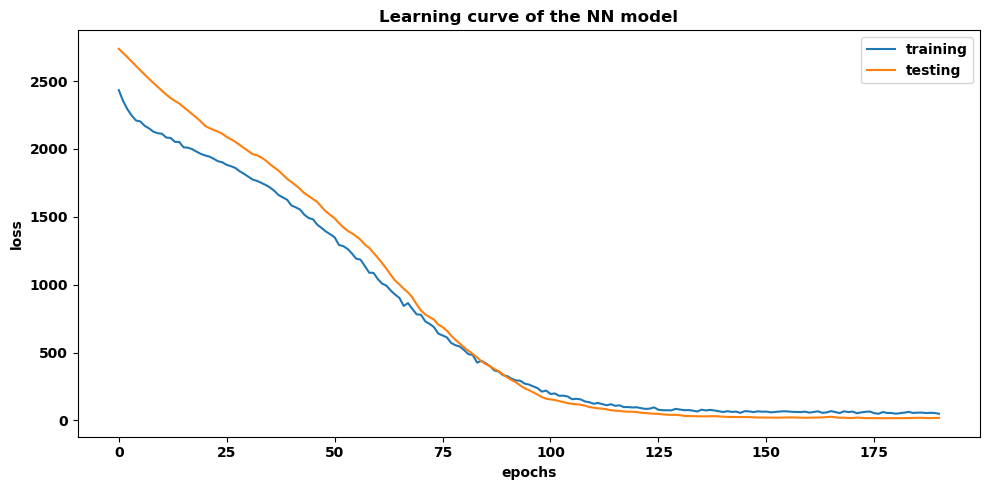

In [19]:
# Plot learning curve of NN model
history = model_NN.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=500, batch_size=128, callbacks=[early_stopping])

plt.figure(figsize = (10, 5))
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'testing')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('Learning curve of the NN model')
plt.legend()

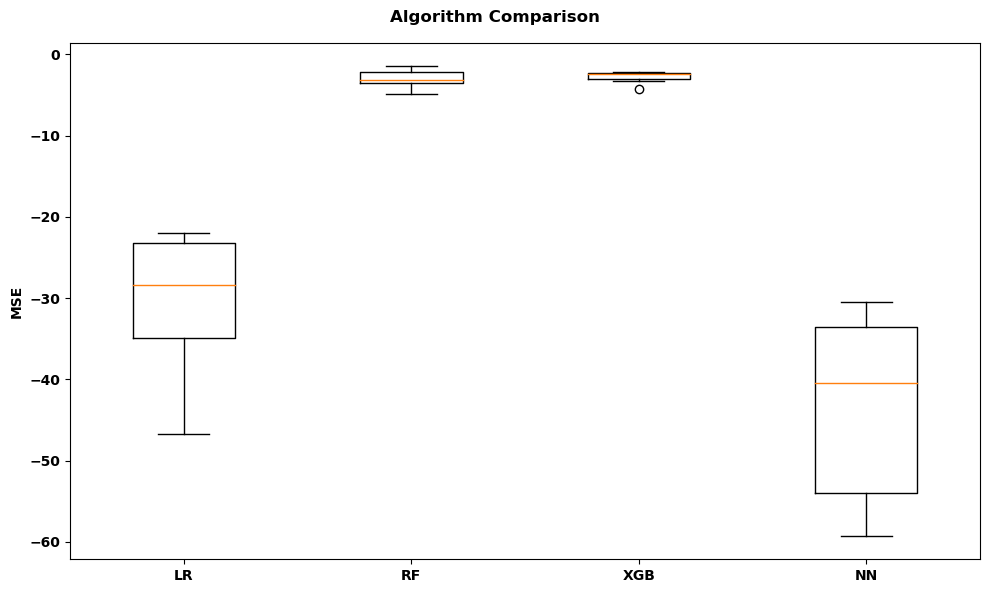

In [20]:
# b) Compare algorithms and the NN model
# Distribution of accuracy values calculated across 8 cross-validation folds.
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot()
plt.boxplot(results)
ax.set_xticklabels(alg_names)
plt.ylabel("MSE")
plt.show()

Of the three algorithms and NN model, the ensemble models outperformed Linear Regression and NN model.

In a regression problem, it is common to use the mean error as a measure of validation. This is done by first calculating the mean absolute error (MAE) of the test data with the mean of dataset, and then calculating the MAE of the test data with the predicted data. 

In [21]:
# Evaluate performance of Random Forest algorithm on validation data
model_RF = RandomForestRegressor(n_estimators=10)
model_RF.fit(X_train, y_train)
y_pred_RF = model_RF.predict(X_val)
mae_pred_RF = mean_absolute_error(y_val, y_pred_RF)
print("Mean Absolute Error of predicted data: ", mae_pred_RF)

Mean Absolute Error of predicted data:  1.2690562770562772


In [22]:
# Evaluate performance of XGBoost algorithm on validation data
model_xgb.fit(X_train1, y_train1)
dtrain = xgb.DMatrix(X_val1)
y_pred_xgb = model_xgb.predict(X_val1)
mae_pred_xgb = mean_absolute_error(y_val, y_pred_xgb)
print("Mean Absolute Error of predicted data: ", mae_pred_xgb)

Mean Absolute Error of predicted data:  1.412210528551242


In [23]:
# Define baseline mean_absolute_error of y_val in the data set
y_mean = np.mean(y)
y_mean = np.array([y_mean]*len(y_val))
mae_ori = mean_absolute_error(y_val, y_mean)
print("Mean Absolute Error of original data: ", mae_ori)

Mean Absolute Error of original data:  17.70811874323593


The resulting MAE values show that Random Forest looks better than XGBoost in prediction performance. For the sake of simplicity, I selected Random Forest as the surrogate model for the optimization process in the 2nd Notebook.

**5. Finalize Model**

In [24]:
# a) Get best model parameters
model_params = model_RF.get_params()

# Print the model's parameters
print(model_params)

{'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


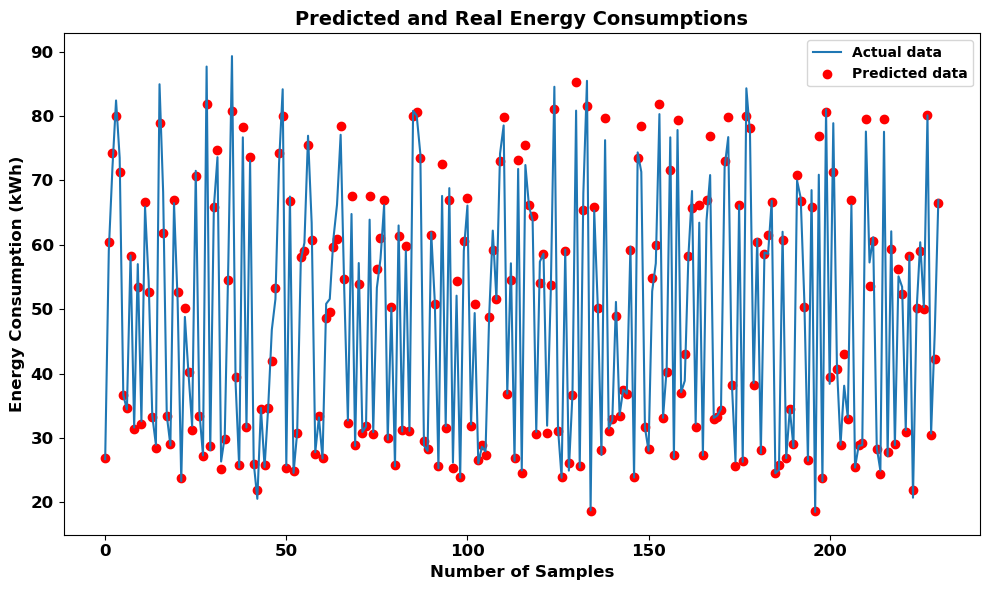

In [25]:
fig, ax = plt.subplots()

# Plot the actual data as a line chart
ax.plot(range(len(y_val)), y_val, label='Actual data')

# Overlay the predicted data as a scatter plot
ax.scatter(range(len(y_pred_RF)), y_pred_RF, label='Predicted data', color='red')

# Add labels, title, and legend
ax.set_xlabel('Number of Samples', fontsize=12)
ax.set_ylabel('Energy Consumption (kWh)', fontsize=12)
ax.set_title('Predicted and Real Energy Consumptions', fontsize=14)
ax.legend()

# set tick font size for both axes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the plot
plt.show()

In [26]:
# b) Save model for later use
# save the model to disk
filename = 'finalized_model.sav'
dump(model_RF, open(filename, 'wb'))

**6. Conclusions**

- Exploratory data analysis shows that most input variables exhibit non-Gaussian distribution.

- Among the three machine learning algorithms and neural network (NN) model, Random Forest and XGBoost attained lowest Mean Squared Error values following cross validation process. The Random Forest algorithm was selected as the surrogate model for optimization process in the 2nd Notebook.

- The Mean Absolute Error values indicate that the prediction accuracy for the ensemble algorithms is excellent, whereas it was unexpectedly low for the NN model.

- The performance of the NN model (Keras Sequential) is worst than all ML algorithms. Further tunning of the hyperparameter may yield a better prediction score.